In [1]:
%cd /content/15x6-sim
# or wherever you cloned it, e.g. /content/drive/MyDrive/Projects/15x6-sim
!pwd
!ls data/
!git clone https://github.com/MementoMori15x6/15x6-sim.git
%cd 15x6-sim
!pip install pandas numpy matplotlib seaborn scipy


[Errno 2] No such file or directory: '/content/15x6-sim'
/content
/content
ls: cannot access 'data/': No such file or directory
Cloning into '15x6-sim'...
remote: Enumerating objects: 888, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 888 (delta 47), reused 27 (delta 27), pack-reused 816 (from 3)
Receiving objects: 100% (888/888), 3.17 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (501/501), done.
/content/15x6-sim


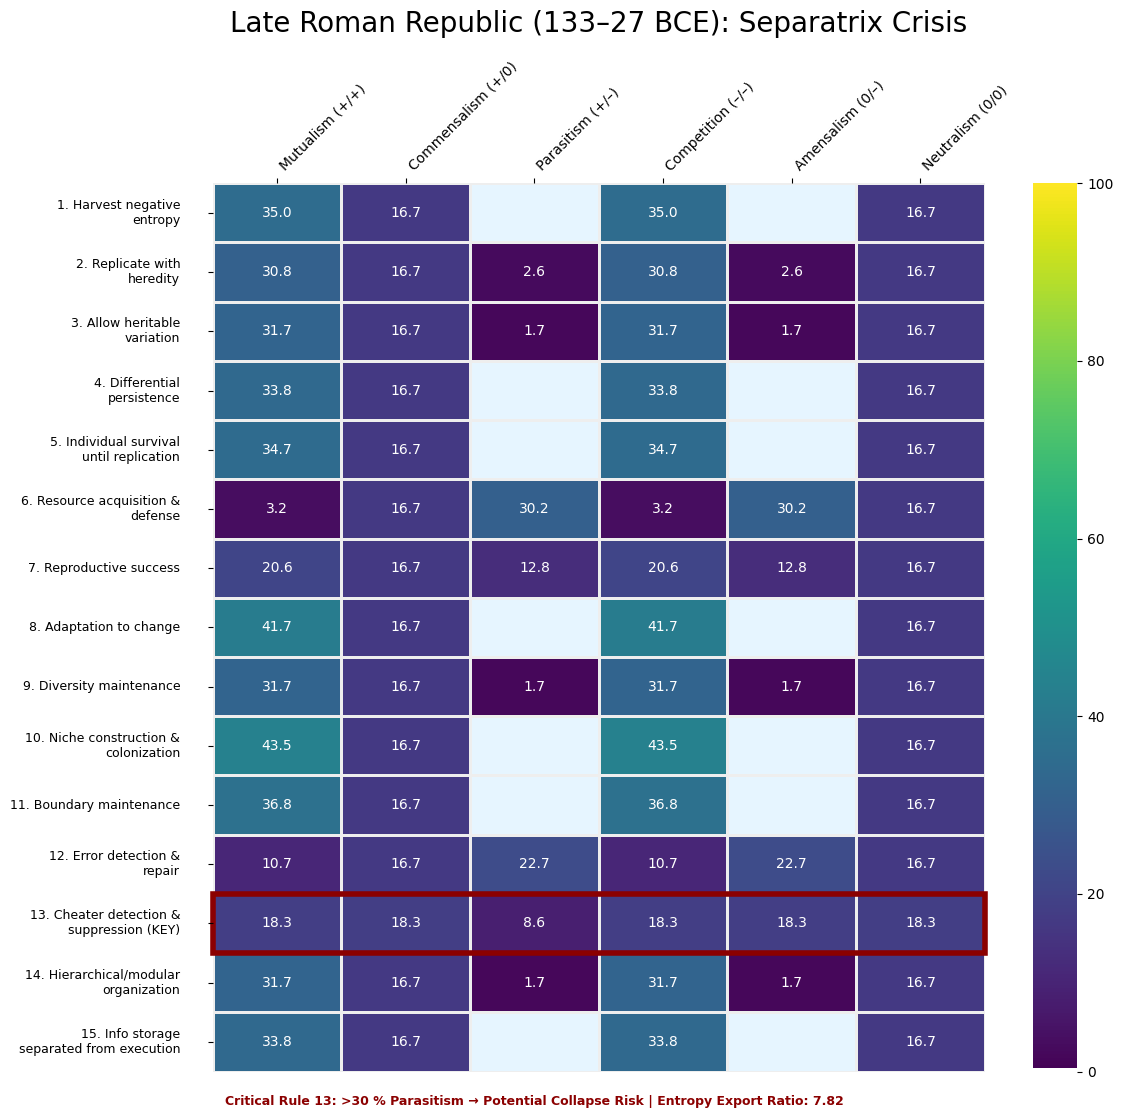

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import textwrap

# ────────────────────────────────────────────────
# Load Late Republic CSV from repo
url = 'https://raw.githubusercontent.com/MementoMori15x6/15x6-sim/main/data/35_metrics_roman_republic_133_27_bce.csv'
df = pd.read_csv(url)
scores = df['Score'].to_numpy(dtype=float)
assert len(scores) == 35

# Penalty function
def penalty(s):
    return s + np.sign(s) * (abs(s) - 8)**2 * 0.5 if abs(s) > 8 else s

adjusted = np.array([penalty(s) for s in scores])

# Rule-13 parasitism %
rule13_idx = [17,18,19,20,21,22,25]
rule13_norm = adjusted[rule13_idx] / 10
parasitism_pct = (np.sum(-rule13_norm[rule13_norm < 0]) / len(rule13_norm) if np.any(rule13_norm < 0) else 0) * 100

# Build matrix
rule_map = [[0,1,2],[5],[6],[7],[10],[3,4],[32],[9],[6],[11],[12],[13],[8,14],[15],[16]]
matrix = np.zeros((15,6))
for i, idxs in enumerate(rule_map):
    m = np.mean(adjusted[idxs]) / 10
    amt = abs(m) * 30
    delta = [amt,0,-amt,amt,-amt,0] if m > 0 else [-amt,0,amt,-amt,amt,0]
    row = (np.ones(6)*(100/6) + delta) / np.sum(np.ones(6)*(100/6) + delta) * 100
    matrix[i] = row

matrix[12,2] = parasitism_pct
matrix[12,[0,1,3,4,5]] = (100 - parasitism_pct) / 5

# ────────────────────────────────────────────────
# Heatmap with fixes for label cropping
rules = [
    "1. Harvest negative entropy",
    "2. Replicate with heredity",
    "3. Allow heritable variation",
    "4. Differential persistence",
    "5. Individual survival until replication",
    "6. Resource acquisition & defense",
    "7. Reproductive success",
    "8. Adaptation to change",
    "9. Diversity maintenance",
    "10. Niche construction & colonization",
    "11. Boundary maintenance",
    "12. Error detection & repair",
    "13. Cheater detection & suppression (KEY)",
    "14. Hierarchical/modular organization",
    "15. Info storage separated from execution"
]

# Wrap long labels
wrapped_rules = ['\n'.join(textwrap.wrap(r, width=25)) for r in rules]

moves = ["Mutualism (+/+)", "Commensalism (+/0)", "Parasitism (+/–)", "Competition (–/–)", "Amensalism (0/–)", "Neutralism (0/0)"]

df_grid = pd.DataFrame(matrix, index=rules, columns=moves)

mask = (df_grid == 0.0) | (df_grid < 0.01)

viridis_base = plt.cm.viridis
newcolors = viridis_base(np.linspace(0, 1, 256))
newcolors[0] = [1,1,1,1]
custom_map = LinearSegmentedColormap.from_list('WhiteViridis', newcolors)

fig, ax = plt.subplots(figsize=(14, 11))  # Slightly taller to help labels
ax.set_facecolor('#E6F5FF')

sns.heatmap(df_grid, annot=True, fmt=".1f", cmap=custom_map, mask=mask,
            vmin=0, vmax=100, linewidths=1, linecolor="#eeeeee", ax=ax)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xticklabels(moves, rotation=45, ha="left", fontsize=10)

# Use wrapped labels
ax.set_yticklabels(wrapped_rules, rotation=0, va="center", fontsize=9)

# Extra padding for y-labels
ax.tick_params(axis='y', which='major', pad=20)

ax.set_title("Late Roman Republic (133–27 BCE): Separatrix Crisis", fontsize=20, pad=20)
ax.add_patch(plt.Rectangle((0,12),6,1, fill=False, edgecolor="#8B0000", lw=4, clip_on=False))

fig.text(0.53, -0.00,
         f"Critical Rule 13: >30 % Parasitism → Potential Collapse Risk | Entropy Export Ratio: {np.mean(matrix[:,0]) / (np.mean(matrix[:,2]) or 1e-6):.2f}",
         fontsize=9, color="#8B0000", ha='center', va='top', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Key fix: extra left margin for wrapped labels
plt.savefig("late_republic_heatmap_fixed.png", dpi=300, bbox_inches="tight")
plt.show()